In [173]:
import pyNetLogo
## package for coupling with netlogo
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from pandas.tseries.offsets import DateOffset
import json
import glob, os, sys
# %matplotlib inline # this seems to be a line for plotting. Comment out for now
## above is from big six model, required packages

netlogo = pyNetLogo.NetLogoLink() #Show NetLogo GUI netlogo . 
netlogo.load_model('CapeTownABM_pyCoupling.nlogo' )
netlogo.command( 'setup' )
netlogo.command( 'load-rain-temp-history' )
netlogo.command('set Scenario 3')
# change range to run for loop the range start with 1 and stop at n-1
use_list = [10000, 10000, 10000]
for i in range (1,2):
    netlogo.command("print ticks")
    netlogo.command('go')
#     netlogo.command('set volume-this-month')
    use = use_list[i - 1]
    words = ['ask one-of Watermanagers [set volume-this-month', str(use), ']'] # this is how to pass a number into netlogo
    netlogo.command(" ".join(words))
    use1 = float(netlogo.report('vol')) # this is how to pass a number from netlogo to python
    netlogo.command('print ticks')
    words = ['ask one-of Weathermans with [identity = "Cape_Point"] [set rainfall-monthly lput 1 rainfall-monthly]']
    netlogo.command(" ".join(words))
    words = ['print item 0 [ (item 120 rainfall-monthly)] of Weathermans with [identity = "Cape_Point"]']
    netlogo.command(" ".join(words))
#     print(use)
#     print(use1)
# # use = 90000
# words = ['ask one-of Watermanagers [set volume-this-month', str(use), ']']

# netlogo.command(" ".join(words))
# netlogo.command('ask one-of Watermanagers [print volume-this-month]')

## above are example codes to control abm model


In [201]:
# pet_sim_1 = pd.read_csv("./data/pet_rsvr_avg_model1.csv",index_col=None)
# pet_sim_1 = pet_sim_1.drop(['Unnamed: 0'],axis = 1)
# pet_sim_1 = pet_sim_1.set_index('month_date')
# pet_sim_1['2009':'2012']

In [204]:
# pr_mon_new['pr'].values.tolist()


In [2]:
#some generic data on dams and catchments
damnames=np.array(["BergRiver","SteenbrasLower","SteenbrasUpper","Theewaterskloof", "Volvlei","Vemmershoek"])
catchmentarea=np.array([172,36,36,176,539,121]) #area of quaternary catchments in which dams are located [km2]
damvolumes=np.array([130010, 33517, 31767, 480188, 164095, 58644]) #maximum volume of dams
damareas=np.array([4.88,3.8,np.nan,50.59,np.nan,2.96]) #area at maximum storage in km2. Not available for all dams\n",
catchmentarea=np.array([172*0.76,36*.54,36*.54,176*1.00,539*0.75,121*0.90]) #this is a fraction of the quaternary catchment that drains to the dam, calculated in GIS from topography\n"

In [120]:
x = netlogo.report("ticks")
x

1.0

In [19]:
### This chunk of code is for loading data. We need to make sure the files is in the same directory
### to do figure out how to run matplotlib in jupyter
pr_mon=pd.read_json("./data/pr_mon_share.json") #in mm/month, from observations (mean of 5 stations located on dams)
# we can overlap the reservoirs with the gridded precipitation data to acquire monthly rainfall.
# plt.plot(pr_mon)
# plt.show()
print("Average monthly precipitation from five stations of the Big Six Reservoirs")
print(pr_mon.head())

dam_mon=pd.read_json("./data/dam_mon_share.json") # in Ml, from CoCT data
# The dam data is historical data from 2008-2018 for calibration and validation.
# plt.plot(dam_mon)
# plt.show()
print("Historical Big Six Dams Stograge ML")
print(dam_mon.head())

agric_mon=pd.read_json("./data/agric_mon_share.json") #in Ml/day, combination of sources - pre 2018 based on disaggregation of annual total, post-2018 - from CoCT water dashboard
# The agircultural data is also from 2008-2018 for same purpose mentioned previously.
# plt.plot(agric_mon)
# plt.show()
print("Historical Agircultural Water Usage ML/day")
print(agric_mon.head())


urban_mon=pd.read_json("./data/urban_mon_share.json") #in Ml/day, based on CoCT data
# The agircultural data is also from 2008-2018 for same purpose mentioned previously.
# plt.plot(urban_mon)
# plt.show()
print("Historical Urban Water Usage ML/day")
print(urban_mon.head())

pet_mon=pd.read_json("./data/pet_mon_share.json") #in mm/month, pre-2018 based on mean of P-M ET0 from ~35 met stations in the region, post-2018 - a repeat of 2018.
# plt.plot(pet_mon)
# plt.show()
print("Historical PET in mm/month")
print(pet_mon.head())


Average monthly precipitation from five stations of the Big Six Reservoirs
            pr
2008-01-31  16
2008-02-29  29
2008-03-31  24
2008-04-30  13
2008-05-31  67
Historical Big Six Dams Stograge ML
               dam
2000-01-31  652498
2000-02-29  573743
2000-03-31  512215
2000-04-30  470869
2000-05-31  471607
Historical Agircultural Water Usage ML/day
            use
2008-01-31  870
2008-02-29  911
2008-03-31  753
2008-04-30  415
2008-05-31   47
Historical Urban Water Usage ML/day
             use
2008-01-31  1017
2008-02-29  1086
2008-03-31  1052
2008-04-30  1002
2008-05-31   874
Historical PET in mm/month
                     0
2006-01-31  151.917214
2006-02-28  141.128877
2006-03-31  121.705950
2006-04-30   80.959417
2006-05-31   46.425187


In [302]:
def bigsix_simple(_catchA, _Pthresh, _ow2pet, _prec, _use, _pet):
    #simple model that does not account for soil moisture, but rather uses rainfall treshold only\n",
    #calculates runoff from catchments and water balance of the dams\n",
    #WE ARE USING the full model, not the simple one.
    #volume-area relationship parameters\n",
    damvolumes=np.array([130010., 33517., 31767., 480188., 164095., 58644.]) #max volume of dams, in Ml\n",
    totstore=np.sum(damvolumes)
    damA=np.array([0.0016, 0.0031,  0.0016,0.0069,  0.0016,0.0016]) #characteristic of individual dams\n",
    damB=0.68 #identical for all dams\n",
    # getting time paramters\n",
    allts=_prec.shape[0] #number of time steps\n",
    print (allts)
    index=_prec.index 

    #preparing arrays to store state variables\n",
    damevap=np.repeat(np.nan, allts).flatten()
    damarea=np.repeat(np.nan, allts).flatten()
    damvolume=np.repeat(np.nan, allts).flatten()
    #initial conditions    \n",
    vol=totstore*0.7
    damvolume[0]=vol
    frac=vol/totstore
    A=np.sum(damA*((damvolumes*frac)**damB))
    damarea[0]=np.sum(damA*(vol**damB))

    nts=min(len(damvolume),_prec.shape[0]) #making sure that calculations are only for period for which all data are available\n",, _use.shape[0]
    
    for i in range(1,nts):
       #picking values from previous time step\n",
        vol=damvolume[i-1]
        A=damarea[i-1]
        #pet\n",
        pet=_pet.values[i] #in mm/month\n",
        owevap=A*pet*ow2pet #km2*mm/month -result in Ml/month\n",
        damevap[i]=owevap/30 #saving in Ml/day\n",
        #effective precipitation\n",
        Peff=_prec.values[i] #in mm/month\n",
        Peff=Peff-_Pthresh
        #making sure that effective is not negative ;-)\n",
        if Peff<0:
            Peff=0
        runoff=Peff*_catchA #roff in mm/month, catchA in km2 result in Ml/month\n",
        use=_use.values[i] #reading water abstractions from dams\n",
        #calculating new dam volume after inflow and outtakes and evaporation\n",
        vol=vol-use-owevap+runoff
        #calculating overflow or spillover
        if vol>totstore:
            spill=vol-totstore
            vol=totstore
        else:
            spill=0
        #making sure dams don't dry below 0\n",
        if vol<0:
            vol=0
        damvolume[i]=vol

        frac=vol/totstore
        A=np.sum(damA*((damvolumes*frac)**damB))  #this is distributed. assumed that dams are filled up uniformily. in km2\n",
        damarea[i]=A

        catchrunoff[i]=runoff

        #preparing output dataframes\n",
        damevap=pd.DataFrame(damevap, index=index)
        catchrunoff=pd.DataFrame(catchrunoff, index=index)
        damarea=pd.DataFrame(damarea, index=index)
        damvolume=pd.DataFrame(damvolume, index=index)

        return damvolume, damevap, damarea, catchrunoff
    

In [304]:
 def bigsix(_catchA, _Pthresh, _beta, _maxsm, _alpha, _smevfac, _ow2pet, _prec, _use, _pet):
    #a more comprehensive model that takes into account soil moisture feedbacks. \n",
    #Rainfall is partitioned into runoff and infiltration based on soil moisture status\n",
    # soil moisture is evaporated as a function of pet and level of saturation\n",
    # there is a simple channel routing function - a linear reservoir routing\n",

    netlogo = pyNetLogo.NetLogoLink() #Show NetLogo GUI netlogo . 
    netlogo.load_model('CapeTownABM_pyCoupling.nlogo' )
    netlogo.command( 'setup' )
    netlogo.command( 'load-rain-temp-history' )
    netlogo.command('set Scenario 3')
    #volume-area relationship parameters
    damvolumes=np.array([130010., 33517., 31767., 480188., 164095., 58644.]) #max volume of dams, in Ml
    totstore=np.sum(damvolumes)
    print (totstore)
    damA=np.array([0.0016, 0.0031,  0.0016,0.0069,  0.0016,0.0016]) #characteristic of individual dams
    damB=0.68 #identical for all dams
    
    _maxsmevap=_smevfac*_maxsm # soil moisture at which there is maximum evaporation, in mm
    
    index=_prec.index #dates of the time series
    
    allts=_prec.shape[0] #number of time steps
    
    #preparing arrays to store state variables
    damevap=np.repeat(np.nan, allts).flatten()
    damarea=np.repeat(np.nan, allts).flatten()
    damvolume=np.repeat(np.nan, allts).flatten()
    soilm=np.repeat(np.nan, _prec.shape[0]).flatten()
    channel=np.repeat(np.nan, allts).flatten()
    catchrunoff=np.repeat(np.nan, _prec.shape[0]).flatten()   
    
    #initial conditions    
    vol=totstore*0.8
    damvolume[0]=vol
    frac=vol/totstore
    A=np.sum(damA*((damvolumes*frac)**damB))
    damarea[0]=np.sum(damA*(vol**damB))
    soilm[0]=_maxsm*0.2 
    channel[0]=10 

    nts=min(len(damvolume),_prec.shape[0]) #making sure that calculations are only for period for which all data are available\n",
    print(len(damvolume))
    print(_prec.shape[0])
    
    for i in range(1,nts):
        #picking values from previous time step - thus initial conditions are needed\n",
        vol=damvolume[i-1]
#         vol = netlogo.report('[volume-this-month] of one-of Watermanagers')
#         print(vol)
        sm=soilm[i-1]
#         print(sm)
        chan=channel[i-1]   
#         print(chan)
        A=damarea[i-1]
#         print(A)

        #pet\n",
        pet=_pet.values[i] #in mm/month\n",
#         print(pet)

        owevap=A*pet*_ow2pet #km2*mm/month -result in Ml/month\n",
#         print(owevap)
        damevap[i]=owevap/30 #saving in Ml/day\n",
#         print(damevap[i])
        #effective precipitation\n",
        Peff=_prec.values[i] #in mm/month\n",
        Peff=Peff-_Pthresh
        #making sure that effective is not negative ;-)\n",
        if Peff<0:
            Peff=0
        # runoff - fraction of Peff that is dependent on soil moisture\n",
        roff=((sm/_maxsm)**_beta)*Peff #in mm/month\n",
        infil=Peff-roff # mm/month - whatever is left after taking runoff off\n",
        sm=sm+infil # mm - soil moisture increase from infiltration\n",
        #evaporation from soil moisture\n",
        if sm>_maxsmevap:
            smevapfrac=1
        else:
            smevapfrac=sm/_maxsmevap
        smevap=smevapfrac*pet # in mm/month\n",
        sm=sm-smevap
        #making sure soil moisture is not negative\n",
        if sm<0:
            sm=0
        #making sure soil moisture does not exceed maximum value\n",
        if sm>_maxsm:
            roff=roff+(sm-_maxsm)
            sm=_maxsm
        #inflow to channel network\n",
        inflow=roff*_catchA #roff in mm/month, catchA in km2 result in Ml/month\n",
        #channel delay
        chan=chan+inflow
        strflow=chan*_alpha
        chan=chan-strflow
        channel[i]=chan
        #########################
        #####netlogo
        ### import netlogo scenario 2 into the bigsix model
#       
        dam_inflow = float(strflow - owevap)
        words = ['ask one-of Watermanagers [set volume-this-month', str(vol), ']']
        netlogo.command(" ".join(words)) # implement the command using the words above
        netlogo.command('go')
        use = float(netlogo.report('vol'))
        words = ['set dam-inflow-monthly lput', str(dam_inflow), 'dam-inflow-monthly']
        netlogo.command(" ".join(words)) # update the dam net inflow at the beginning of the month
#         print(dam_inflow)
#         print("command processed")
# #         words = ['set tickss', str(i), ']'] # change the ticks in scenario 2
# #         netlogo.command(" ".join(words)) # implement the command using the words above
#         netlogo.command('ask one-of Watermanagers [print volume-this-month]')
#         netlogo.command('print ticks')
#         use=_use.values[i] #reading water abstractions from dams\n", 
        ### the use above is the place where we need to set the use from the abm
        #########################
        
        #calculating new dam volume after inflow and outtakes and evaporation\n",
        vol=vol-use-owevap+strflow
        #calculating overflow or spillover\n",
        if vol>totstore:
            spill=vol-totstore
            vol=totstore
        else:
            spill=0
        #making sure dams don't dry below 0\n",
        if vol<0:
            vol=0
        damvolume[i]=vol

        frac=vol/totstore
        A=np.sum(damA*((damvolumes*frac)**damB))  #this is distributed. assumed that dams are filled up uniformily. in km2\n",
        damarea[i]=A

        soilm[i]=sm
        catchrunoff[i]=strflow

    #preparing dataframes\n",
    damevap=pd.DataFrame(damevap, index=index)
    soilm=pd.DataFrame(soilm, index=index)
    catchrunoff=pd.DataFrame(catchrunoff, index=index)
    damarea=pd.DataFrame(damarea, index=index)
    damvolume=pd.DataFrame(damvolume, index=index)
    
    return damvolume, damevap, damarea, soilm, catchrunoff
# bigsix(catchA, Pthresh, beta, maxsm, alpha, smevfac,ow2pet, prec_inp,use_inp,pet_inp)

In [188]:
# netlogo.report['last total-allocation-monthly']
pr_mon.head()
pet_mon.head() # start from 2006-01-31 to 2019-07-31
pet_mon.columns
# dam_mon # start from 2000-01-31 to 2019-07-31
# urban_mon # start from 2008-01-31 to 2019-07-31
# agric_mon.head() # start from 2008-01-31 to 2019-07-31

Int64Index([0], dtype='int64')

In [280]:
dam_inflow = 1 - 1
words = ['set dam-inflow-monthly lput', str(dam_inflow), 'dam-inflow-monthly']
print(" ".join(words))

set dam-inflow-monthly lput 0 dam-inflow-monthly


In [101]:
# this is for pr_mon # start from 2008-01-31 to 2019-07-31
pr_mon_new = pr_mon['2008':'2014']
dt = pd.date_range("2019-08-30", periods = 12*7, freq = "M")
# print(pr_mon['2008':'2015'])
pr_mon_new.index = dt
# print(pr_mon_new)
frames = [pr_mon, pr_mon_new]
pr_mon_new = pd.concat(frames)


# this is for pet_mon # start from 2000-01-31 to 2019-07-31
pet_mon_new = pet_mon['2008':'2014']
dt = pd.date_range("2019-08-30", periods = 12*7, freq = "M")
# print(pr_mon['2008':'2015'])
pet_mon_new.index = dt
# print(pr_mon_new)
frames = [pet_mon, pet_mon_new]
pet_mon_new = pd.concat(frames)


# this is for dam_mon # start from 2000-01-31 to 2019-07-31
dam_mon_new = dam_mon['2008':'2014']
dt = pd.date_range("2019-08-30", periods = 12*7, freq = "M")
# print(pr_mon['2008':'2015'])
dam_mon_new.index = dt
# print(pr_mon_new)
frames = [dam_mon, dam_mon_new]
dam_mon_new = pd.concat(frames)

# this is for urban_mon # start from 2008-01-31 to 2019-07-31
urban_mon_new = urban_mon['2008':'2014']
dt = pd.date_range("2019-08-30", periods = 12*7, freq = "M")
# print(pr_mon['2008':'2015'])
urban_mon_new.index = dt
# print(pr_mon_new)
frames = [urban_mon, urban_mon_new]
urban_mon_new = pd.concat(frames)

# this is for agric_mon # start from 2008-01-31 to 2019-07-31
agric_mon_new = agric_mon['2008':'2014']
dt = pd.date_range("2019-08-30", periods = 12*7, freq = "M")
# print(pr_mon['2008':'2015'])
agric_mon_new.index = dt
# print(pr_mon_new)
frames = [agric_mon, agric_mon_new]
agric_mon_new = pd.concat(frames)


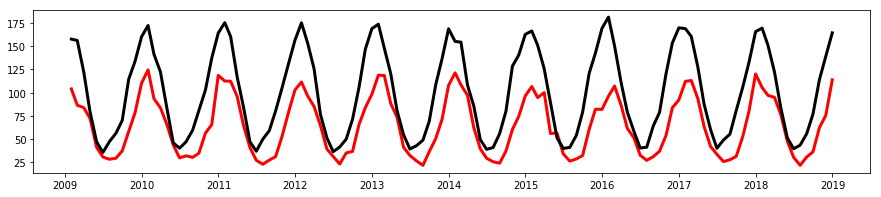

In [308]:
# new simulated data read in
dt = pd.date_range("2009-01-31", periods = (12* (2100 - 2009 + 1)), freq = "M")
pet_sim_1 = pd.read_csv("./data/pet_mon_Sim1.csv",index_col=None)
pet_sim_1 = pet_sim_1.drop(['Unnamed: 0'],axis = 1)
pet_sim_1 = pet_sim_1.set_index('month_date')
pet_sim_1.index = dt
# pet_sim_1['2009':'2012']

pet_sim_2 = pd.read_csv("./data/pet_mon_Sim2.csv",index_col=None)
pet_sim_2 = pet_sim_2.drop(['Unnamed: 0'],axis = 1)
pet_sim_2 = pet_sim_2.set_index('month_date')
pet_sim_2.index = dt
# pet_sim_2['2009':'2012']

pet_sim_3 = pd.read_csv("./data/pet_mon_Sim3.csv",index_col=None)
pet_sim_3 = pet_sim_3.drop(['Unnamed: 0'],axis = 1)
pet_sim_3 = pet_sim_3.set_index('month_date')
pet_sim_3.index = dt
# pet_sim_3['2009':'2012']

pet_sim_4 = pd.read_csv("./data/pet_mon_Sim4.csv",index_col=None)
pet_sim_4 = pet_sim_4.drop(['Unnamed: 0'],axis = 1)
pet_sim_4 = pet_sim_4.set_index('month_date')
pet_sim_4.index = dt
# print(pet_sim_4['2009':'2012'])
# print(pet_mon['2009':'2012'])

fig=plt.figure(figsize=(15,3))
# pl = fig.add_subplot(1, 1, 1)
plt.plot(pet_sim_1['2009':'2018']*1.4, color="red", label="Sim1", linewidth=3 )
# plt.plot(pet_sim_2['2009':'2100']*1.4, color="blue", label="Sim2", linewidth=3 )
# plt.plot(pet_sim_3['2009':'2100']*1.4, color="green", label="Sim3", linewidth=3 )
# plt.plot(pet_sim_4['2009':'2100']*1.4, color="yellow", label="Sim4", linewidth=3 )
plt.plot(pet_mon['2009':'2018'], color="black", label="observed", linewidth=3 )
plt.show()

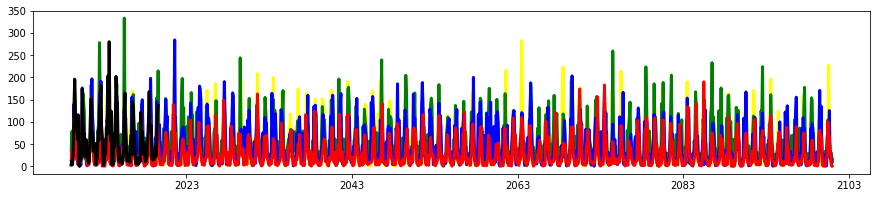

In [314]:
 #new simulated data read in
dt = pd.date_range("2009-01-31", periods = (12* (2100 - 2009 + 1)), freq = "M")
pr_sim_1 = pd.read_csv("./data/pr_mon_Sim1.csv",index_col=None)
pr_sim_1 = pr_sim_1.drop(['Unnamed: 0'],axis = 1)
pr_sim_1 = pr_sim_1.set_index('month_date')
pr_sim_1.index = dt
# pet_sim_1['2009':'2012']

pr_sim_2 = pd.read_csv("./data/pr_mon_Sim2.csv",index_col=None)
pr_sim_2 = pr_sim_2.drop(['Unnamed: 0'],axis = 1)
pr_sim_2 = pr_sim_2.set_index('month_date')
pr_sim_2.index = dt
# pet_sim_2['2009':'2012']

pr_sim_3 = pd.read_csv("./data/pr_mon_Sim3.csv",index_col=None)
pr_sim_3 = pr_sim_3.drop(['Unnamed: 0'],axis = 1)
pr_sim_3 = pr_sim_3.set_index('month_date')
pr_sim_3.index = dt
# pet_sim_3['2009':'2012']

pr_sim_4 = pd.read_csv("./data/pr_mon_Sim4.csv",index_col=None)
pr_sim_4 = pr_sim_4.drop(['Unnamed: 0'],axis = 1)
pr_sim_4 = pr_sim_4.set_index('month_date')
pr_sim_4.index = dt
# print(pet_sim_4['2009':'2012'])
# print(pet_mon['2009':'2012'])

fig=plt.figure(figsize=(15,3))
# pl = fig.add_subplot(1, 1, 1)
plt.plot(pr_sim_4['2009':'2100'], color="yellow", label="Sim4", linewidth=3 )
plt.plot(pr_sim_3['2009':'2100'], color="green", label="Sim3", linewidth=3 )
plt.plot(pr_sim_2['2009':'2100'], color="blue", label="Sim2", linewidth=3 )
plt.plot(pr_sim_1['2009':'2100'], color="red", label="Sim1", linewidth=3 )
plt.plot(pr_mon['2009':'2100'], color="black", label="observed", linewidth=3 )
plt.show()

In [152]:
# agric_mon_new["2019":"2024"]

In [297]:
#preparing data for simulations

ldate="2100 December"
# prec_inp=pr_mon['2009':ldate]
# pet_inp=pet_mon['2009':ldate]
# dam_inp=dam_mon['2009':ldate]
# use_inp=urban_mon['2009':ldate]*30+agric_mon['2009':ldate]*30 #in Ml/month
prec_inp=pr_mon_new['2009':ldate]
pet_inp=pet_mon_new['2009':ldate]
### using simulated data
prec_inp=pr_sim_4['2009':ldate]
pet_inp=pet_sim_4['2009':ldate]
dam_inp=dam_mon_new['2009':ldate]
use_inp=urban_mon_new['2009':ldate]*30+agric_mon_new['2009':ldate]*30 #in Ml/month

898221.0
1104
1104


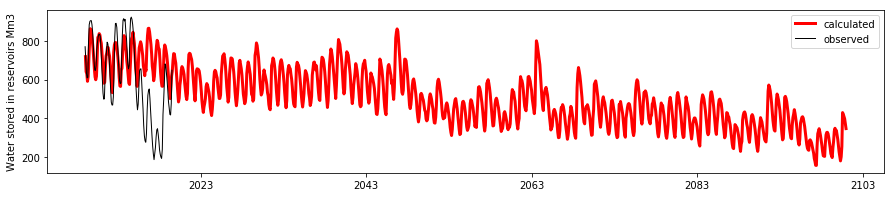

In [305]:
catchA=1000 #catchment area from data - it's not exactly the size of the catchments, but that does not matter much as total catchment rainfall is calculated as a simple mean of individual stations, while in reality is should be a weighted mean\n",

#paramters  - these were formally obtained by automatic calibration on the 2009-2015 data.\n",
Pthresh=0 #rainfall threshold for calculating effective rainfall\n",
beta=0.143 #infiltration-runoff partitioning\n",
maxsm=100 #max soil moisture in partitioning function, but also in soil evaporation function\n",
alpha=1 #channel network linear reservoir coefficient\n",
smevfac=1.7 # soil moisture evaporation parameter\n",

ow2pet=1.2 #ratio of open water to PET, assumed rather than calibrated\n",


damvolume, damevap, damarea, soilm, catchrunoff=bigsix(catchA, Pthresh, beta, maxsm, alpha, smevfac,ow2pet, prec_inp,use_inp,pet_inp)


fig=plt.figure(figsize=(15,3))
pl = fig.add_subplot(1, 1, 1)
pl.plot(damvolume/1000, color="red", label="calculated", linewidth=3)
pl.plot(dam_mon['2009':ldate].index-pd.Timedelta('15days'), dam_mon['2009':ldate].values/1000, color="black", label="observed", lw=1)
pl.set_ylabel("Water stored in reservoirs Mm3")
pl.legend()
# pl.set_ylim(100,1000)
# xticks=pd.date_range("2009-01-01", "2020-01-01", freq="AS")
# pl.set_xlim("2008-01-01", "2021-01-01")
# pl.set_xticks(xticks)
plt.show()
# plt.savefig('bigsix_sim_obs.png')

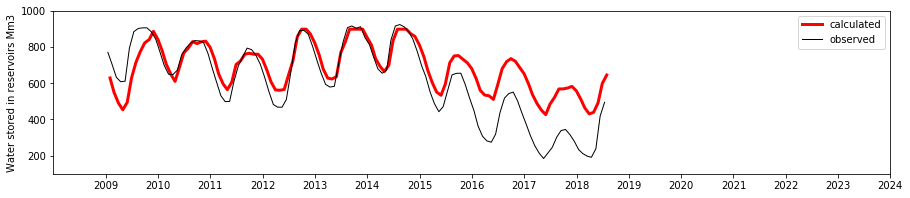

In [150]:
fig=plt.figure(figsize=(15,3))
pl = fig.add_subplot(1, 1, 1)
pl.plot(damvolume/1000, color="red", label="calculated", linewidth=3)
pl.plot(dam_mon['2009':ldate].index-pd.Timedelta('15days'), dam_mon['2009':ldate].values/1000, color="black", label="observed", lw=1)
pl.set_ylabel("Water stored in reservoirs Mm3")
pl.legend()
pl.set_ylim(100,1000)
xticks=pd.date_range("2009-01-01", "2024-07-01", freq="AS")
pl.set_xlim("2008-01-01", "2021-01-01")
pl.set_xticks(xticks)
plt.show()

In [299]:
print(damvolume)

                        0
2009-01-31  718576.800000
2009-02-28  640606.045683
2009-03-31  630221.338318
2009-04-30  590553.213821
2009-05-31  614744.463029
2009-06-30  706137.462618
2009-07-31  793508.372326
2009-08-31  863651.086168
2009-09-30  855794.205458
2009-10-31  835101.072102
2009-11-30  801726.399468
2009-12-31  760515.201302
2010-01-31  705284.621541
2010-02-28  656179.869363
2010-03-31  612898.933926
2010-04-30  598803.717079
2010-05-31  616313.406689
2010-06-30  706520.913359
2010-07-31  818916.391197
2010-08-31  823243.772182
2010-09-30  838034.293378
2010-10-31  830934.456896
2010-11-30  804409.468050
2010-12-31  787998.885181
2011-01-31  738606.193373
2011-02-28  692219.329133
2011-03-31  633287.073536
2011-04-30  580487.386958
2011-05-31  586277.582771
2011-06-30  662060.593563
...                   ...
2098-07-31            NaN
2098-08-31            NaN
2098-09-30            NaN
2098-10-31            NaN
2098-11-30            NaN
2098-12-31            NaN
2099-01-31  

In [155]:
# print(catchrunoff)

SyntaxError: invalid syntax (<ipython-input-283-dc1e2a2642ce>, line 1)